# Μοντελοποίηση: Ταξινόμηση Κατανάλωσης Ενέργειας

## Στόχος
Πρόβλεψη εάν η ημερήσια κατανάλωση ενέργειας είναι **Υψηλή** ή **Χαμηλή** σε σχέση με τον εποχιακό μέσο όρο του νοικοκυριού.

## Προσέγγιση
- **Target**: Season-adjusted high consumption (>15% πάνω από εποχιακό μέσο όρο)
- **Features**: Μόνο past-known features (lags, rolling stats, calendar)
- **Μοντέλα**: Logistic Regression → Random Forest → XGBoost/LightGBM
- **Αξιολόγηση**: Accuracy, Precision, Recall, F1-Score, ROC-AUC

## Αποφυγή Data Leakage
✅ Χρήση μόνο features που είναι γνωστά **πριν** την ημέρα πρόβλεψης  
✅ Season means υπολογίζονται **μόνο από train set**  
✅ Scalers fit **μόνο στο train**

---
## 1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay
)

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

DATA_DIR = Path('..') / 'data'
RESULTS_DIR = Path('..') / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print('✅ Imports completed successfully')
print(f'📁 Data directory: {DATA_DIR.absolute()}')
print(f'📊 Results directory: {RESULTS_DIR.absolute()}')

✅ Imports completed successfully
📁 Data directory: /home/konstantinos-papadogiannis/energy-data-mining/notebooks/../data
📊 Results directory: /home/konstantinos-papadogiannis/energy-data-mining/notebooks/../results


---
## 2. Φόρτωση Δεδομένων

Φορτώνουμε τα **raw** (μη κανονικοποιημένα) ημερήσια δεδομένα από το preprocessing.

In [2]:
# Φόρτωση train/val/test sets
train = pd.read_csv(DATA_DIR / 'train_raw.csv', parse_dates=True, index_col=0)
val = pd.read_csv(DATA_DIR / 'val_raw.csv', parse_dates=True, index_col=0)
test = pd.read_csv(DATA_DIR / 'test_raw.csv', parse_dates=True, index_col=0)

print('📊 Dataset Shapes:')
print(f'  Train: {train.shape} ({train.index.min().date()} → {train.index.max().date()})')
print(f'  Val:   {val.shape} ({val.index.min().date()} → {val.index.max().date()})')
print(f'  Test:  {test.shape} ({test.index.min().date()} → {test.index.max().date()})')

print('\n📋 Available columns:', train.shape[1])
print('\n🔍 First 3 rows of train:')
train.head(3)

📊 Dataset Shapes:
  Train: (987, 48) (2007-01-15 → 2009-09-27)
  Val:   (211, 48) (2009-09-28 → 2010-04-26)
  Test:  (213, 48) (2010-04-27 → 2010-11-25)

📋 Available columns: 48

🔍 First 3 rows of train:


,Daily_total_power,Daily_mean_power,Daily_peak_power,Daily_min_power,Daily_std_power,Global_reactive_power_sum,Global_reactive_power_mean,Voltage_mean,Voltage_std,Global_intensity_mean,Global_intensity_max,Sub_metering_1_sum,Sub_metering_2_sum,Sub_metering_3_sum,Peak_hour_power,Nighttime_usage,Morning_usage,Afternoon_usage,DayOfWeek,IsWeekend,Month,Season,Year,DayOfYear,Next_day_consumption,lag_1,lag_7,lag_14,lag_30,rolling_mean_7d,rolling_std_7d,rolling_median_7d,rolling_min_7d,rolling_max_7d,ema_7d,ema_30d,diff_1d,diff_7d,Total_submetering,Sub1_ratio,Sub2_ratio,Sub3_ratio,Other_consumption,Power_factor,Peak_to_total_ratio,Night_to_total_ratio,Morning_to_total_ratio,High_Consumption
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-15,35.811,1.492,5.896,0.208,0.961,2.914,0.121,241.241,3.098,6.262,25.2,1099.0,2239.0,15163.0,9.586,8.330,9.671,8.225,0,0,1,Winter,2007,15,28.107,50.184,37.356,45.817,20.153,38.523,10.108,37.356,24.355,53.114,41.327,37.364,-14.373,-1.545,18501.0,0.031,0.063,0.423,17.310,0.925,0.268,0.233,0.270,1
2007-01-16,28.107,1.171,5.570,0.212,0.996,3.090,0.129,241.945,2.711,4.976,23.2,2063.0,644.0,6583.0,7.885,3.826,6.198,10.197,1,0,1,Winter,2007,16,47.461,35.811,31.151,21.154,56.508,38.302,10.154,35.913,24.355,53.114,39.948,37.264,-7.705,-3.044,9290.0,0.073,0.023,0.234,18.817,0.901,0.281,0.136,0.221,1
2007-01-17,47.461,1.978,8.000,0.206,1.438,3.346,0.139,241.005,2.781,8.284,34.2,3500.0,5737.0,16064.0,11.041,6.900,15.991,13.530,2,0,1,Winter,2007,17,30.358,28.107,35.913,16.901,36.730,37.867,10.568,35.913,24.355,53.114,36.988,36.673,19.355,11.548,25301.0,0.074,0.121,0.338,22.160,0.934,0.233,0.145,0.337,1


---
## 3. Ορισμός Target: Season-Adjusted High Consumption

### Γιατί Season-Adjusted;
Η κατανάλωση ενέργειας εξαρτάται **πολύ** από την εποχή:
- **Χειμώνας**: ~33 kWh/day (θέρμανση)
- **Καλοκαίρι**: ~17 kWh/day (χωρίς θέρμανση)

Αν χρησιμοποιήσουμε **έναν** μέσο όρο για όλο το χρόνο, όλες οι χειμωνιάτικες μέρες θα είναι "high" και όλες οι καλοκαιρινές "low", που δεν είναι χρήσιμο.

### Λύση
Συγκρίνουμε κάθε μέρα με τον **εποχιακό** μέσο όρο της:
- **High Consumption** = Κατανάλωση > 1.15 × εποχιακός μέσος όρος (15% πάνω)
- **Normal/Low Consumption** = Κατανάλωση ≤ 1.15 × εποχιακός μέσος όρος

### Αποφυγή Data Leakage
✅ Υπολογίζουμε τους εποχιακούς μέσους **μόνο από το train set**  
✅ Εφαρμόζουμε τους ίδιους μέσους στο val και test

In [3]:
# Υπολογισμός εποχιακών μέσων όρων ΑΠΟ TRAIN ΜΟΝΟ
season_means = train.groupby('Season')['Daily_total_power'].mean()

print('📊 Εποχιακοί Μέσοι Όροι Κατανάλωσης (από train set):')
print(season_means.sort_values(ascending=False).round(2))
print(f'\n📈 Διαφορά Winter vs Summer: {(season_means["Winter"] - season_means["Summer"]):.2f} kWh/day')
print(f'   Ποσοστό: {(season_means["Winter"] / season_means["Summer"] - 1)*100:.1f}% περισσότερο το χειμώνα')

📊 Εποχιακοί Μέσοι Όροι Κατανάλωσης (από train set):
Season
Winter    33.31
Autumn    27.02
Spring    26.46
Summer    17.21
Name: Daily_total_power, dtype: float64

📈 Διαφορά Winter vs Summer: 16.10 kWh/day
   Ποσοστό: 93.5% περισσότερο το χειμώνα


In [4]:
# Υπολογισμός season-adjusted deviation για κάθε set
THRESHOLD = 1.15  # 15% πάνω από εποχιακό μέσο = High

# Train
train['season_mean'] = train['Season'].map(season_means)
train['deviation_ratio'] = train['Daily_total_power'] / train['season_mean']
y_train = (train['deviation_ratio'] > THRESHOLD).astype(int)

# Validation (χρήση train season_means!)
val['season_mean'] = val['Season'].map(season_means)
val['deviation_ratio'] = val['Daily_total_power'] / val['season_mean']
y_val = (val['deviation_ratio'] > THRESHOLD).astype(int)

# Test (χρήση train season_means!)
test['season_mean'] = test['Season'].map(season_means)
test['deviation_ratio'] = test['Daily_total_power'] / test['season_mean']
y_test = (test['deviation_ratio'] > THRESHOLD).astype(int)

print(f'🎯 Target Definition: High Consumption = deviation_ratio > {THRESHOLD}')
print(f'   (i.e., >15% πάνω από τον εποχιακό μέσο όρο)\n')

print('📊 Target Distribution:')
print(f'  Train: {y_train.value_counts().to_dict()} → {y_train.value_counts(normalize=True).round(3).to_dict()}')
print(f'  Val:   {y_val.value_counts().to_dict()} → {y_val.value_counts(normalize=True).round(3).to_dict()}')
print(f'  Test:  {y_test.value_counts().to_dict()} → {y_test.value_counts(normalize=True).round(3).to_dict()}')

print('\n✅ Target is balanced (not too imbalanced)')

🎯 Target Definition: High Consumption = deviation_ratio > 1.15
   (i.e., >15% πάνω από τον εποχιακό μέσο όρο)

📊 Target Distribution:
  Train: {0: 703, 1: 284} → {0: 0.712, 1: 0.288}
  Val:   {0: 160, 1: 51} → {0: 0.758, 1: 0.242}
  Test:  {0: 153, 1: 60} → {0: 0.718, 1: 0.282}

✅ Target is balanced (not too imbalanced)


---
## 4. Επιλογή Features (Χωρίς Data Leakage)

### Κανόνας
Χρησιμοποιούμε **μόνο** features που είναι γνωστά **πριν** την ημέρα που θέλουμε να προβλέψουμε.

### ✅ Safe Features (OK to use)
1. **LAG features**: `lag_1`, `lag_7`, `lag_14`, `lag_30` (χθεσινή, προηγούμενης εβδομάδας κτλ)
2. **Rolling statistics**: `rolling_mean_7d`, `rolling_std_7d`, κτλ (υπολογισμένα από παρελθόν)
3. **EMA**: `ema_7d`, `ema_30d` (exponential moving average)
4. **Differences**: `diff_1d`, `diff_7d` (αλλαγές από χθες/προηγούμενη εβδομάδα)
5. **Calendar features**: `DayOfWeek`, `Month`, `Season`, `IsWeekend`, κτλ (γνωστά εκ των προτέρων)

### ❌ Forbidden Features (Data Leakage!)
- `Daily_total_power` (αυτό προσπαθούμε να προβλέψουμε!)
- `Daily_mean_power`, `Daily_peak_power` (same-day aggregates)
- `Peak_hour_power`, `Nighttime_usage` (same-day)
- `Total_submetering`, `Sub1_ratio`, κτλ (same-day)
- `Next_day_consumption` (μελλοντική τιμή!)

In [5]:
# Ορισμός safe features
safe_features = [
    # LAG features (past values)
    'lag_1', 'lag_7', 'lag_14', 'lag_30',
    
    # Rolling statistics (computed from past)
    'rolling_mean_7d', 'rolling_std_7d', 'rolling_median_7d',
    'rolling_min_7d', 'rolling_max_7d',
    
    # Exponential moving averages
    'ema_7d', 'ema_30d',
    
    # Differences (changes from past)
    'diff_1d', 'diff_7d',
    
    # Calendar features (known in advance)
    'DayOfWeek', 'IsWeekend', 'Month', 'Season', 'Year', 'DayOfYear'
]

# Έλεγχος ότι όλα τα features υπάρχουν
missing_features = [f for f in safe_features if f not in train.columns]
if missing_features:
    print(f'⚠️  Missing features: {missing_features}')
    safe_features = [f for f in safe_features if f in train.columns]

print(f'✅ Using {len(safe_features)} safe features (no data leakage):')
for i, f in enumerate(safe_features, 1):
    print(f'  {i:2d}. {f}')

✅ Using 19 safe features (no data leakage):
   1. lag_1
   2. lag_7
   3. lag_14
   4. lag_30
   5. rolling_mean_7d
   6. rolling_std_7d
   7. rolling_median_7d
   8. rolling_min_7d
   9. rolling_max_7d
  10. ema_7d
  11. ema_30d
  12. diff_1d
  13. diff_7d
  14. DayOfWeek
  15. IsWeekend
  16. Month
  17. Season
  18. Year
  19. DayOfYear


In [6]:
# Δημιουργία X (features) και y (target) με ευθυγράμμιση
X_train = train[safe_features].copy()
X_val = val[safe_features].copy()
X_test = test[safe_features].copy()

# Αφαίρεση NaN rows (από lag/rolling features)
train_mask = X_train.notna().all(axis=1)
X_train = X_train[train_mask]
y_train_aligned = y_train[train_mask]

val_mask = X_val.notna().all(axis=1)
X_val = X_val[val_mask]
y_val_aligned = y_val[val_mask]

test_mask = X_test.notna().all(axis=1)
X_test = X_test[test_mask]
y_test_aligned = y_test[test_mask]

print('📊 Final Dataset Shapes (after removing NaN):')
print(f'  X_train: {X_train.shape}, y_train: {y_train_aligned.shape}')
print(f'  X_val:   {X_val.shape}, y_val:   {y_val_aligned.shape}')
print(f'  X_test:  {X_test.shape}, y_test:  {y_test_aligned.shape}')

print('\n✅ No missing values in features')
print(f'✅ X and y are aligned (same indices)')

📊 Final Dataset Shapes (after removing NaN):
  X_train: (987, 19), y_train: (987,)
  X_val:   (211, 19), y_val:   (211,)
  X_test:  (213, 19), y_test:  (213,)

✅ No missing values in features
✅ X and y are aligned (same indices)


---
## 5. Preprocessing Pipeline

Δημιουργούμε pipeline που:
1. **OneHotEncoder** για categorical features (`Season`)
2. **StandardScaler** για numeric features
3. Fit **μόνο στο train**, transform σε train/val/test

In [7]:
# Διαχωρισμός σε categorical και numeric features
categorical_features = ['Season']
numeric_features = [f for f in safe_features if f not in categorical_features]

print(f'📊 Feature Types:')
print(f'  Categorical: {categorical_features}')
print(f'  Numeric: {len(numeric_features)} features')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='drop'
)

print('\n✅ Preprocessing pipeline created')
print('   - OneHotEncoder for Season (4 categories → 4 binary columns)')
print('   - StandardScaler for numeric features (mean=0, std=1)')

📊 Feature Types:
  Categorical: ['Season']
  Numeric: 18 features

✅ Preprocessing pipeline created
   - OneHotEncoder for Season (4 categories → 4 binary columns)
   - StandardScaler for numeric features (mean=0, std=1)


In [8]:
# Helper function για αξιολόγηση μοντέλων
def evaluate_model(y_true, y_pred, y_proba, set_name=''):
    """Υπολογίζει και εκτυπώνει μετρικές αξιολόγησης"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f'\n📊 {set_name} Set Results:')
    print(f'  Accuracy:  {acc*100:.2f}%')
    print(f'  Precision: {prec*100:.2f}%')
    print(f'  Recall:    {rec*100:.2f}%')
    print(f'  F1-Score:  {f1*100:.2f}%')
    print(f'  ROC-AUC:   {auc*100:.2f}%')
    
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}

print('✅ Helper function defined')

✅ Helper function defined


---
---
# ΜΟΝΤΕΛΟ 1: Logistic Regression (Baseline)

## Γιατί Logistic Regression;
- ✅ **Γρήγορο** και απλό
- ✅ **Interpretable** (μπορούμε να δούμε τα coefficients)
- ✅ Καλό **baseline** για σύγκριση με πιο πολύπλοκα μοντέλα
- ✅ Λειτουργεί καλά όταν τα features είναι κανονικοποιημένα

## Παράμετροι
- `max_iter=1000`: Αρκετές επαναλήψεις για σύγκλιση
- `random_state=42`: Για reproducibility

In [9]:
# Δημιουργία pipeline: preprocessing + model
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print('🤖 Model: Logistic Regression')
print('   Parameters: max_iter=1000, random_state=42')
print('\n🔄 Training...')

# Εκπαίδευση
logistic_pipeline.fit(X_train, y_train_aligned)

print('✅ Training completed!')

🤖 Model: Logistic Regression
   Parameters: max_iter=1000, random_state=42

🔄 Training...
✅ Training completed!


In [10]:
# Προβλέψεις
y_train_pred_lr = logistic_pipeline.predict(X_train)
y_val_pred_lr = logistic_pipeline.predict(X_val)
y_test_pred_lr = logistic_pipeline.predict(X_test)

# Probabilities (για ROC-AUC)
y_train_proba_lr = logistic_pipeline.predict_proba(X_train)[:, 1]
y_val_proba_lr = logistic_pipeline.predict_proba(X_val)[:, 1]
y_test_proba_lr = logistic_pipeline.predict_proba(X_test)[:, 1]

print('='*70)
print('LOGISTIC REGRESSION - EVALUATION')
print('='*70)

lr_train_metrics = evaluate_model(y_train_aligned, y_train_pred_lr, y_train_proba_lr, 'Train')
lr_val_metrics = evaluate_model(y_val_aligned, y_val_pred_lr, y_val_proba_lr, 'Validation')
lr_test_metrics = evaluate_model(y_test_aligned, y_test_pred_lr, y_test_proba_lr, 'Test')

print('\n' + '='*70)

LOGISTIC REGRESSION - EVALUATION

📊 Train Set Results:
  Accuracy:  97.97%
  Precision: 98.89%
  Recall:    94.01%
  F1-Score:  96.39%
  ROC-AUC:   99.90%

📊 Validation Set Results:
  Accuracy:  96.68%
  Precision: 92.31%
  Recall:    94.12%
  F1-Score:  93.20%
  ROC-AUC:   99.79%

📊 Test Set Results:
  Accuracy:  97.18%
  Precision: 95.00%
  Recall:    95.00%
  F1-Score:  95.00%
  ROC-AUC:   99.77%



In [11]:
print('📋 Detailed Classification Report (Validation Set):\n')
print(classification_report(y_val_aligned, y_val_pred_lr, 
                          target_names=['Normal/Low (0)', 'High (1)'],
                          digits=3))

📋 Detailed Classification Report (Validation Set):

                precision    recall  f1-score   support

Normal/Low (0)      0.981     0.975     0.978       160
      High (1)      0.923     0.941     0.932        51

      accuracy                          0.967       211
     macro avg      0.952     0.958     0.955       211
  weighted avg      0.967     0.967     0.967       211



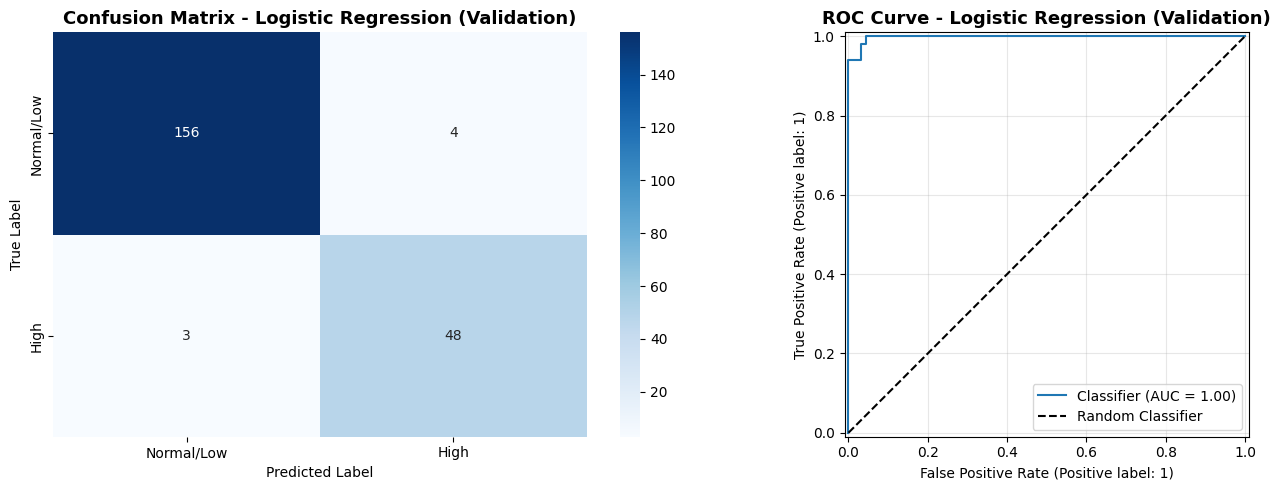

✅ Visualization saved to results/logistic_regression_eval.png


In [12]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_val_aligned, y_val_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal/Low', 'High'],
            yticklabels=['Normal/Low', 'High'])
axes[0].set_title('Confusion Matrix - Logistic Regression (Validation)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# ROC Curve
RocCurveDisplay.from_predictions(y_val_aligned, y_val_proba_lr, ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_title('ROC Curve - Logistic Regression (Validation)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'logistic_regression_eval.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Visualization saved to results/logistic_regression_eval.png')